In [18]:
# import cf, cfplot as cfp
import numpy as np
import scipy as sp
import sys
import os
from netCDF4 import Dataset
import netCDF4 as nc
%matplotlib inline
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import warnings

import matplotlib.pyplot as plt
import matplotlib.path as mpath
# Quick plot to show the results
from cartopy import config
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.basemap import addcyclic
from cartopy.util import add_cyclic_point
import matplotlib.pylab as pl
from scipy import stats
import regionmask
import glob
import dask
from general_functions import *
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [19]:
def rebase(dataset,files):
    # ds = xr.open_dataset('intermediate_files/stable/gmst/tas_gmst_bq777.nc') #,engine='zarr')
    dates=dataset[0,].dropna(dim='year',how='all').year  
    datasets = []
    test=dataset
    for i in np.arange(0,int(dataset.shape[0])):
        tmp=test[i,:].dropna(dim='year',how='all')
        # print(tmp)
        # print(tmp.shape)
        # print(dates)
        tmp['year']=dates
#         print(tmp.year)
        datasets.append(tmp)
    dsnew = xr.concat(datasets, dim='cases')
    # print(dsnew)
    return(dsnew)
def preprocess(ds):
    print(ds.encoding['source'])
    return(ds)

def seasaverage_3(var,seas):
    season={'DJF':0,'JFM':1,'FMA':2,'MAM':3,'AMJ':4,'MJJ':5,'JJA':6,'JAS':7,'ASO':8,'SON':9,'OND':10,'NDJ':11,'ann':None}
    seasindex=season[seas]
    if (seas == 'ann'):
        var_seas=var.groupby('time.year').mean('time')
    else:
        if (var.ndim == 4):
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[:,seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time') #rename({"time":"year"})
        elif (var.ndim == 3): 
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time')
        # print(var_seas)
    return(var_seas)

In [20]:
factor={'tas':1,'pr':86400,'txx':1,'psl':1./100,'ua_850':1.,'evspsbl':86400,'va_850':1.,'uas':1.,'vas':1.,'msftyz':(1./(1000*1e6))}
zipgmststab=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc'))
zipgmst=xr.open_mfdataset(zipgmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
zipgmst=np.nanmean(rebase(zipgmst,zipgmststab),axis=1)
# print(zipgmst)
def sortbygmst(input):
    input = [x for _,x in sorted(zip(zipgmst,input))]
    return(input)
def lonflip(var):
    var.coords['lon'] = xr.where(var.coords['lon'] > 180, var.coords['lon'] - 360, var.coords['lon'])
    var = var.sortby("lon", ascending=True)
    return(var)
def real_timeseries(nyear=1,seas='ann',var='tas',var2='tas',lat1=None,lat2=None,lon1=None,lon2=None):

    fileshist=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/historical/'+var+'/'+var+'_r*.nc'))
    hist=seasaverage_3(xr.open_mfdataset(fileshist,combine='nested',concat_dim='cases')[var2],seas)*factor[var] # gmst timeseries for all hist runs --> baseperiod
    # print(hist)
    lat=hist['lat']
    lon=hist['lon']
    # base=hist[:,-30:,:,:].mean('cases').mean('year')
    base=hist[:,0:50,:,:].mean('cases').mean('year')
    files=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/'+var+'/'+var+'_?????.nc')))
    print(files)
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='cases',preprocess=preprocess)
    tas=seasaverage_3(ds[var2],seas)*factor[var]
    year=tas.year
    print(tas.lon)
    if (var == 'txx'):
        tas=tas.rename({'latitude':'lat','longitude':'lon'})
    print("rebasing...")
    if (var != 'pr'):
        tas_anom=tas-base
    else:
        tas_anom=100*(tas-base)/base
    landmask='/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/sftlf/gn/latest/sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
    ds1 = xr.open_dataset(landmask)
    landfrac=ds1['sftlf']/100.
    seafrac=1-landfrac

    mlat=ds['lat']
    weights = np.cos(np.deg2rad(mlat))
    weights.name = "weights"

    if (lat1 != None):
        tas_sub = lonflip(tas_anom).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        weights_sub = weights.sel(lat=slice(lat1, lat2))
        tas_anom=tas_sub
        print(tas_anom.lon)
        weights=weights_sub
        landfrac=lonflip(landfrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        seafrac=lonflip(seafrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

    GMST=tas_anom.weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    land=(mask_land(tas_anom)).weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    print(land)
    sea=(tas_anom).weighted(weights*seafrac).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    
    return(land,sea,GMST)

def transient_timeseries(nyear=1,seas='ann',var='tas',var2='tas',lat1=None,lat2=None,lon1=None,lon2=None):

    fileshist=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/historical/'+var+'/'+var+'_r*.nc'))
    hist=seasaverage_3(xr.open_mfdataset(fileshist,combine='nested',concat_dim='cases')[var2],seas)*factor[var] # gmst timeseries for all hist runs --> baseperiod
    # print(hist)
    lat=hist['lat']
    lon=hist['lon']
    # base=hist[:,-30:,:,:].mean('cases').mean('year')
    base=hist[:,0:50,:,:].mean('cases').mean('year')
    files=sorted(glob.glob('EMs/'+var+'_Amon_UKESM1-0-LL_ssp370_ensmean_gn_*nc'))
    print(files)
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',preprocess=preprocess)
    tas=seasaverage_3(ds[var2],seas)*factor[var]
    year=tas.year
    print(tas.lon)
    if (var == 'txx'):
        tas=tas.rename({'latitude':'lat','longitude':'lon'})
    print("rebasing...")
    if (var != 'pr'):
        tas_anom=tas-base
    else:
        tas_anom=100*(tas-base)/base
    landmask='/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/sftlf/gn/latest/sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
    ds1 = xr.open_dataset(landmask)
    landfrac=ds1['sftlf']/100.
    seafrac=1-landfrac

    mlat=ds['lat']
    weights = np.cos(np.deg2rad(mlat))
    weights.name = "weights"

    if (lat1 != None):
        tas_sub = lonflip(tas_anom).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        weights_sub = weights.sel(lat=slice(lat1, lat2))
        tas_anom=tas_sub
        print(tas_anom.lon)
        weights=weights_sub
        landfrac=lonflip(landfrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        seafrac=lonflip(seafrac).sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

    GMST=tas_anom.weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    land=(mask_land(tas_anom)).weighted(weights).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    print(land)
    sea=(tas_anom).weighted(weights*seafrac).mean(("lat", "lon")).rolling(year=nyear, center=True).mean()
    
    return(land,sea,GMST)

/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bu607.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc


In [21]:
tas_land, tas_sea, GMST = real_timeseries() #lat1=10,lat2=60,lon1=-100,lon2=50)
pr_land, pr_sea, pr_global = real_timeseries(var='pr',var2='pr')
pr_land_t, pr_sea_t, pr_global_t = transient_timeseries(var='pr',var2='pr')
tas_land_t, tas_sea_t, GMST_t = transient_timeseries(var='tas',var2='tas')

['/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bq777.nc', '/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bw848.nc', '/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bz227.nc', '/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_cd269.nc', '/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bw987.nc', '/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bu607.nc']
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/tas/tas_bu607.nc
<xarray.DataArray 'lo

/gws/nopw/j04/realproj/users/adittus/cdds/u-bq777/cdds_data/CMIP6/CMIP/UKESM1-0-LL/piControl/r1i1p1f2/round-8/output/onm/Omon/msftyz/msftyz_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_201401-204912.nc
/gws/nopw/j04/realproj/users/adittus/cdds/u-bq777/cdds_data/CMIP6/CMIP/UKESM1-0-LL/piControl/r1i1p1f2/round-8/output/onm/Omon/msftyz/msftyz_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_205001-214912.nc
/gws/nopw/j04/realproj/users/adittus/cdds/u-bq777/cdds_data/CMIP6/CMIP/UKESM1-0-LL/piControl/r1i1p1f2/round-8/output/onm/Omon/msftyz/msftyz_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_215001-224912.nc
/gws/nopw/j04/realproj/users/adittus/cdds/u-bq777/cdds_data/CMIP6/CMIP/UKESM1-0-LL/piControl/r1i1p1f2/round-8/output/onm/Omon/msftyz/msftyz_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_225001-234912.nc
/gws/nopw/j04/realproj/users/adittus/cdds/u-bq777/cdds_data/CMIP6/CMIP/UKESM1-0-LL/piControl/r1i1p1f2/round-8/output/onm/Omon/msftyz/msftyz_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_235001-244912.nc
/gws/nopw/j04/realpr

/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


Coordinates:
    sector   |S21 dask.array<chunksize=(), meta=np.ndarray>
    lev      float64 814.1
    rlat     float64 40.29
    year     int64 2501
[2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027
 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041
 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055
 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069
 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083
 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097
 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111
 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125
 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139
 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153
 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167
 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 21

/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


Coordinates:
    sector   |S21 dask.array<chunksize=(), meta=np.ndarray>
    lev      float64 814.1
    rlat     float64 40.29
    year     int64 2291
[2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033
 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047
 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061
 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075
 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089
 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103
 2104 2105 2106 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117
 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131
 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145
 2146 2147 2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159
 2160 2161 2162 2163 2164 2165 2166 2167 2168 2169 2170 2171 2172 2173
 2174 2175 2176 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186 21

/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


Coordinates:
    sector   |S21 dask.array<chunksize=(), meta=np.ndarray>
    lev      float64 814.1
    rlat     float64 40.29
    year     int64 2271
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052
 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066
 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080
 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094
 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108
 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122
 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136
 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150
 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164
 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178
 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189 2190 2191 21

/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


Coordinates:
    sector   |S21 dask.array<chunksize=(), meta=np.ndarray>
    lev      float64 901.1
    rlat     float64 40.29
    year     int64 2031
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052
 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066
 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080
 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094
 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108
 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122
 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136
 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150
 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164
 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178
 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189 2190 2191 21

/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


Coordinates:
    sector   |S21 dask.array<chunksize=(), meta=np.ndarray>
    lev      float64 901.1
    rlat     float64 40.29
    year     int64 2033
[2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043
 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057
 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071
 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085
 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099
 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111 2112 2113
 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127
 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141
 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153 2154 2155
 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167 2168 2169
 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181 2182 2183
 2184 2185 2186 2187 2188 2189 2190 2191 2192 2193 2194 2195 2196 21

/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


2
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r2i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r2i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r2i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r2i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


3
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r3i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r3i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r3i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r3i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


4
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r4i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r4i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r4i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r4i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


5
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r5i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r5i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r5i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r5i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


6
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r6i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r6i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r6i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r6i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


7
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r7i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r7i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r7i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r7i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


8
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r8i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r8i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r8i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r8i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


9
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r9i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r9i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r9i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r9i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


10
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r10i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r10i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r10i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r10i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


11
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r11i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r11i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r11i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r11i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


12
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r12i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r12i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r12i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r12i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


16
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r16i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r16i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r16i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r16i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


17
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r17i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r17i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r17i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r17i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


18
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r18i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r18i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r18i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r18i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


19
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r19i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r19i1p1f2_gn_201501-204912.nc
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r19i1p1f2/Omon/msftyz/gn/latest/msftyz_Omon_UKESM1-0-LL_ssp370_r19i1p1f2_gn_205001-210012.nc


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


[[nan nan]
 [nan nan]]


/tmp/ipykernel_701/3762677761.py:34: RuntimeWarning: Mean of empty slice
  plt.plot(amoc_year2[:,0],np.nanmean(amoc_t,axis=1),c='black')


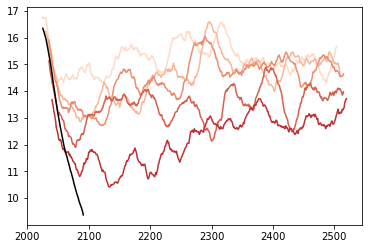

In [14]:
cmap = plt.cm.get_cmap('RdBu_r')
col=np.linspace(0.6,1,7)
var='msftyz'
i=0
amoc=np.full((500,7),np.nan)
amoc_year=np.full((500,7),np.nan)
for run in ['bq777','bw848','bz227','cd269','bw987']:
    files=glob.glob('/gws/nopw/j04/realproj/users/adittus/cdds/u-'+run+'/cdds_data/CMIP6/CMIP/UKESM1-0-LL/piControl/r*i1p1f2/round-8/output/onm/Omon/msftyz/*nc')
# # print(files)
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',preprocess=preprocess)
# # print(ds['rlat'].values)
    var_ann=seasaverage_3(ds['msftyz'],'ann').sel(rlat=40.,method='nearest',tolerance=0.5)
    print(var_ann.where(var_ann==var_ann.max(), drop=True).squeeze().coords)
    amoc[:,i]=(var_ann[:,0,:].max(dim='lev').rolling(min_periods=20, center=True, year=20).mean().values)*factor['msftyz']
    # amoc[:,i]=(var_ann[:,0,:].sel(lev=814.1).rolling(min_periods=20, center=True, year=20).mean().values)*factor['msftyz']
    plt.plot(var_ann['year'].values,amoc[:,i],c=cmap(col[i]))
    amoc_year[:,i]=var_ann['year'].values
    print(var_ann['year'].values)
    i+=1

amoc_t=np.full((86,20),np.nan)
amoc_year2=np.full((86,16),np.nan) 
i=0
for r in np.arange(0,20):
    files=glob.glob('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r'+str(r)+'i1p1f2/Omon/msftyz/gn/latest/*nc')
    if (files):
        print(r)
        ds2=xr.open_mfdataset(files,combine='nested',concat_dim='time',preprocess=preprocess)
# print(ds['rlat'].values)
        var_ann2=seasaverage_3(ds2['msftyz'],'ann').sel(rlat=40.,method='nearest',tolerance=0.5)
        amoc_t[:,i]=(var_ann2[:,0,:].max(dim='lev').rolling(min_periods=20, center=True, year=20).mean())*factor['msftyz']
        amoc_year2[:,i]=var_ann2['year'].values
        i=i+1
plt.plot(amoc_year2[:,0],np.nanmean(amoc_t,axis=1),c='black')
    
print(np.corrcoef(amoc[:,0],amoc[:,1]))

hello


/tmp/ipykernel_701/335762587.py:44: RuntimeWarning: Mean of empty slice
  ax[3].plot(amoc_year2[:,0],np.nanmean(amoc_t,axis=1),c=cmap(col[6]),linestyle='dashed')


<Figure size 432x288 with 0 Axes>

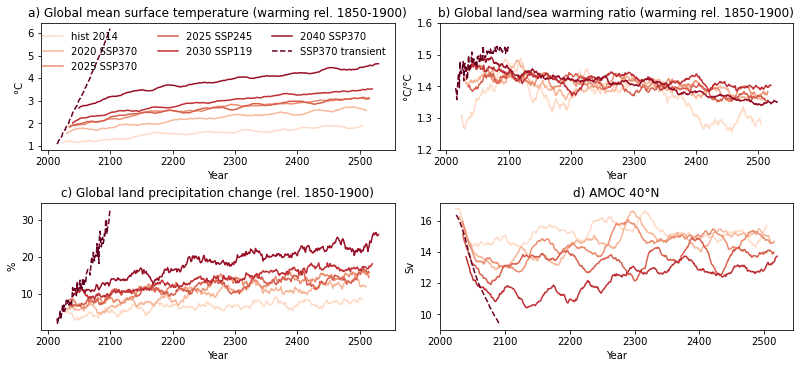

In [17]:
print('hello')
base_period_string='1850-1900'
reg='Global'
linelist=[]
# runid=['hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370','SSP370 parent transient run']
# fig, axlist = plt.subplots(nrows=3, ncols=2, figsize=(11, 5), constrained_layout=True) # figsize width then height
cmap = plt.cm.get_cmap('RdBu_r')
col=np.linspace(0.6,1,7) #np.linspace(0.6,1,7)
# ax=axlist.flatten()
# for i in np.arange(0,6):
#     test=ax[i].plot(tas_land[i,]/tas_sea[i,],c=cmap(col[i]))
#     ax[i].set_ylim(0.5,2.2)
#     ax[i].set_title(reg+' land/sea warming ratio rel. 1984-2014')
#     ax[i].legend(test, [runid[i]],frameon=False,fontsize=10)
plt.savefig(reg+'_land-sea warming ratio_rel1984.eps')
fig, axlist = plt.subplots(nrows=2, ncols=2, figsize=(11, 5), constrained_layout=True)
ax=axlist.flatten()
for i in np.arange(0,6):
    lines,=ax[0].plot(GMST[i,].year,GMST[i,].rolling(min_periods=20, center=True, year=20).mean().values,c=cmap(col[i]))
    linelist.append(lines)  
    ax[0].set_title('a) Global mean surface temperature (warming rel. '+base_period_string+')')
    ax[0].set_ylabel("°C")
    ax[0].set_xlabel("Year")
    ax[1].plot(tas_land[i,].year,(tas_land[i,]/tas_sea[i,]).rolling(min_periods=20, center=True, year=20).mean().values,c=cmap(col[i]))
    ax[1].set_title('b) '+reg+' land/sea warming ratio (warming rel. '+base_period_string+')')
    ax[1].set_ylim(1.2,1.6)
    ax[1].set_ylabel("°C/°C")
    ax[1].set_xlabel("Year")
    ax[2].plot(pr_land[i,].year,pr_land[i,].rolling(min_periods=20, center=True, year=20).mean().values,c=cmap(col[i]))
    ax[2].set_title('c) '+reg+' land precipitation change (rel. '+base_period_string+')')
    ax[2].set_ylabel("%")
    ax[2].set_xlabel("Year")
    # ax[3].plot(pr_sea[i,],c=cmap(col[i]))
    # ax[3].set_title(reg+' ocean precipitation change (rel. '+base_period_string+')')
    # ax[3].set_ylabel("%")
    ax[3].plot(amoc_year[:,i],amoc[:,i],c=cmap(col[i]))
    ax[3].set_title('d) AMOC 40°N')
    ax[3].set_ylabel("Sv")
    ax[3].set_xlabel("Year")
lines,=ax[0].plot(GMST_t.year,GMST_t.rolling(min_periods=1, center=True, year=1).mean().values,c=cmap(col[6]),linestyle='dashed')
linelist.append(lines)  
ax[1].plot(pr_land_t.year,(tas_land_t/tas_sea_t).rolling(min_periods=1, center=True, year=1).mean().values,c=cmap(col[6]),linestyle='dashed')
ax[2].plot(pr_land_t.year,pr_land_t.rolling(min_periods=1, center=True, year=1).mean().values,c=cmap(col[6]),linestyle='dashed')
ax[3].plot(amoc_year2[:,0],np.nanmean(amoc_t,axis=1),c=cmap(col[6]),linestyle='dashed')
ax[0].legend([linelist[0],linelist[1],linelist[2],linelist[3],linelist[4],linelist[5],linelist[6]], ['hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370','SSP370 transient'],frameon=False,fontsize=10, ncol=3)
plt.savefig(reg+'_land-sea_gmst_1fig_'+base_period_string+'.png',dpi=300)
    # ax[1].legend([test[0],test[1],test[2],test[3],test[4],test[5],test[6]], ['hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370','SSP370 parent transient run'],frameon=False,fontsize=10)